In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error as mape

In [2]:
# Read Excel file and save as DataFrame

df = pd.read_excel('./Datasets/tobacco_data.xlsx')
df.columns = df.iloc[0]
df = df[1:]
df.head()

,Intervention_descriptor,tax_increase,outlet_reduction,dec_smoking_prevalence,dec_tobacco_supply,dec_smoking_uptake,age,gender,ethnicity,discount_rate,evidence_strength,qalys_pc,hs_costs_pc
1,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,0-14,Male,non-Māori,0,NaN,40.865526,-1284765.096725
2,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,15-24,Male,non-Māori,0,NaN,41.708939,-1270055.987675
3,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,25-44,Male,non-Māori,0,NaN,13.282615,-318700.524314
4,Combined tobacco endgame strategy (tobacco-fre...,10,90,1,0,0,45-64,Male,non-Māori,0,NaN,7.222291,-119003.652181
5,Combined tobacco endgame strategy (tobacco-fre...,10,90,0.5,0,0,65+,Male,non-Māori,0,NaN,1.111505,-9656.694651


In [3]:
# Transform data

# Map age group to integer
avg_age_mapping = {
    '0-14': 7,
    '15-24': 20,
    '25-44': 33,
    '45-64': 55,
    '65+': 75
}

# Map gender to integer
gender_mapping = {
    'Male': 0,
    'Female': 1
}

# Map ethnicity to integer
ethnicity_mapping = {
    'Māori': 0,
    'non-Māori': 1
}

# Apply the mapping to the 'Age_Group' column
df['average_age'] = df['age'].map(avg_age_mapping)
df['gender_idx'] = df['gender'].map(gender_mapping)
df['ethnicity_idx'] = df['ethnicity'].map(ethnicity_mapping)

# Convert the specified columns to floats
df[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
    'dec_tobacco_supply', 'dec_smoking_uptake']] = df[['tax_increase', 'outlet_reduction', 
    'dec_smoking_prevalence', 'dec_tobacco_supply', 'dec_smoking_uptake']].apply(pd.to_numeric, errors='coerce').astype('float')

# Display the updated DataFrame
df.head()

,Intervention_descriptor,tax_increase,outlet_reduction,dec_smoking_prevalence,dec_tobacco_supply,dec_smoking_uptake,age,gender,ethnicity,discount_rate,evidence_strength,qalys_pc,hs_costs_pc,average_age,gender_idx,ethnicity_idx
1,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,7.0,0.0,0.0,0-14,Male,non-Māori,0,NaN,40.865526,-1284765.096725,7.0,0.0,1.0
2,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,7.0,0.0,0.0,15-24,Male,non-Māori,0,NaN,41.708939,-1270055.987675,20.0,0.0,1.0
3,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,7.0,0.0,0.0,25-44,Male,non-Māori,0,NaN,13.282615,-318700.524314,33.0,0.0,1.0
4,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,1.0,0.0,0.0,45-64,Male,non-Māori,0,NaN,7.222291,-119003.652181,55.0,0.0,1.0
5,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,0.5,0.0,0.0,65+,Male,non-Māori,0,NaN,1.111505,-9656.694651,75.0,0.0,1.0


In [4]:
np.random.seed(42)
data = pd.concat([df]*10, ignore_index=True)
numeric_columns = ['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                       'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 'qalys_pc', 'hs_costs_pc']

# Add Gaussian noise to the numeric columns with a standard deviation of 0.1
for col in numeric_columns:
    data[col] += np.random.normal(0, 0.1, data[col].shape)

In [5]:
np.random.seed(42)
# Define dependent and independent variables
X = np.array(data[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                   'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
                   'gender_idx', 'ethnicity_idx']])

y = np.array(data[['qalys_pc', 'hs_costs_pc']])

# List of different values of n_estimators and max_depth to test
n_estimators_list = list(range(10, 100, 10))
max_depths_list = list(range(5, 25, 5))
    
# 2D Array to store MAPE for different n_estimators and values
mape_qalys_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))
mape_costs_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))

# KFold cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over the values of n_estimators and max_depth
for i in range(len(n_estimators_list)):
    for j in range(len(max_depths_list)):
        # Initialize the RandomForestRegressor with the current n_estimators and max_depth
        rf1 = RandomForestRegressor(n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42, bootstrap=False)
        rf2 = RandomForestRegressor(n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42, bootstrap=False)

        mape_qaly_fold = []
        mape_cost_fold = []

        # Perform cross-validation
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Train the model on the training data for QALYs and costs
            rf1.fit(X_train, y_train[:, 0])
            rf2.fit(X_train, y_train[:, 1])

            # Make predictions on the validation set
            y_pred_qaly = rf1.predict(X_val)
            y_pred_cost = rf2.predict(X_val)

            mape_qaly_fold.append(mape(y_val[:, 0], y_pred_qaly))
            mape_cost_fold.append(mape(y_val[:, 1], y_pred_cost))

        # Store the average MAPE for the current configuration
        mape_qalys_arr[i][j] = np.mean(mape_qaly_fold)
        mape_costs_arr[i][j] = np.mean(mape_cost_fold)

# Retrieve best hyperparameters
qaly_min_index = np.unravel_index(np.argmin(mape_qalys_arr), mape_qalys_arr.shape)
qaly_n_estimators = n_estimators_list[qaly_min_index[0]]
qaly_max_depth = max_depths_list[qaly_min_index[1]]
    
hse_min_index = np.unravel_index(np.argmin(mape_costs_arr), mape_costs_arr.shape)
hse_n_estimators = n_estimators_list[hse_min_index[0]]
hse_max_depth = max_depths_list[hse_min_index[1]]
    
# Training using best n_estimators and max_depth with cross-validation
rf1_best = RandomForestRegressor(n_estimators=qaly_n_estimators, max_depth=qaly_max_depth, random_state=42, bootstrap=False)
rf2_best = RandomForestRegressor(n_estimators=hse_n_estimators, max_depth=hse_max_depth, random_state=42, bootstrap=False)

# train_test_split to test best model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the best models on the entire dataset
rf1_best.fit(X_train, y_train[:, 0])
rf2_best.fit(X_train, y_train[:, 1])

# Make predictions on the entire dataset for final evaluation
qaly_pred = rf1_best.predict(X_test)
cost_pred = rf2_best.predict(X_test)

# Compute MAPE for the entire dataset
mape_qaly_final = mape(y_test[:, 0], qaly_pred)
mape_cost_final = mape(y_test[:, 1], cost_pred)

print(f'n_estimators for QALYs = {qaly_n_estimators}')
print(f'max_depth for QALYs = {qaly_max_depth}')
print(f'MAPE for QALYs: {mape_qaly_final}')
print("----------------------------------")
print(f'n_estimators for Health System Cost = {hse_n_estimators}')
print(f'max_depth for Health System Cost = {hse_max_depth}')
print(f'MAPE for Health System Cost: {mape_cost_final}')

n_estimators for QALYs = 80
max_depth for QALYs = 20
MAPE for QALYs: 0.03884918088416084
----------------------------------
n_estimators for Health System Cost = 10
max_depth for Health System Cost = 10
MAPE for Health System Cost: 1.218418922699531


In [6]:
np.random.seed(42)
# Define dependent and independent variables
X = np.array(data[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                   'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
                   'gender_idx', 'ethnicity_idx']])

y = np.array(data[['qalys_pc', 'hs_costs_pc']])

# List of different values of n_estimators and max_depth to test
n_estimators_list = list(range(10, 100, 10))
max_depths_list = list(range(5, 25, 5))
    
# 2D Array to store MAPE for different n_estimators and values
mape_qalys_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))
mape_costs_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))

# KFold cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over the values of n_estimators and max_depth
for i in range(len(n_estimators_list)):
    for j in range(len(max_depths_list)):
        # Initialize the RandomForestRegressor with the current n_estimators and max_depth
        rf1 = RandomForestRegressor(n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42, bootstrap=True)
        rf2 = RandomForestRegressor(n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42, bootstrap=True)

        mape_qaly_fold = []
        mape_cost_fold = []

        # Perform cross-validation
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Train the model on the training data for QALYs and costs
            rf1.fit(X_train, y_train[:, 0])
            rf2.fit(X_train, y_train[:, 1])

            # Make predictions on the validation set
            y_pred_qaly = rf1.predict(X_val)
            y_pred_cost = rf2.predict(X_val)

            mape_qaly_fold.append(mape(y_val[:, 0], y_pred_qaly))
            mape_cost_fold.append(mape(y_val[:, 1], y_pred_cost))

        # Store the average MAPE for the current configuration
        mape_qalys_arr[i][j] = np.mean(mape_qaly_fold)
        mape_costs_arr[i][j] = np.mean(mape_cost_fold)

# Retrieve best hyperparameters
qaly_min_index = np.unravel_index(np.argmin(mape_qalys_arr), mape_qalys_arr.shape)
qaly_n_estimators = n_estimators_list[qaly_min_index[0]]
qaly_max_depth = max_depths_list[qaly_min_index[1]]
    
hse_min_index = np.unravel_index(np.argmin(mape_costs_arr), mape_costs_arr.shape)
hse_n_estimators = n_estimators_list[hse_min_index[0]]
hse_max_depth = max_depths_list[hse_min_index[1]]
    
# Training using best n_estimators and max_depth with cross-validation
rf1_best = RandomForestRegressor(n_estimators=qaly_n_estimators, max_depth=qaly_max_depth, random_state=42, bootstrap=True)
rf2_best = RandomForestRegressor(n_estimators=hse_n_estimators, max_depth=hse_max_depth, random_state=42, bootstrap=True)

# train_test_split to test best model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the best models on the entire dataset
rf1_best.fit(X_train, y_train[:, 0])
rf2_best.fit(X_train, y_train[:, 1])

# Make predictions on the entire dataset for final evaluation
qaly_pred = rf1_best.predict(X_test)
cost_pred = rf2_best.predict(X_test)

# Compute MAPE for the entire dataset
mape_qaly_final = mape(y_test[:, 0], qaly_pred)
mape_cost_final = mape(y_test[:, 1], cost_pred)

print(f'n_estimators for QALYs = {qaly_n_estimators}')
print(f'max_depth for QALYs = {qaly_max_depth}')
print(f'MAPE for QALYs: {mape_qaly_final}')
print("----------------------------------")
print(f'n_estimators for Health System Cost = {hse_n_estimators}')
print(f'max_depth for Health System Cost = {hse_max_depth}')
print(f'MAPE for Health System Cost: {mape_cost_final}')

n_estimators for QALYs = 20
max_depth for QALYs = 20
MAPE for QALYs: 0.423776635102404
----------------------------------
n_estimators for Health System Cost = 10
max_depth for Health System Cost = 10
MAPE for Health System Cost: 3.422715691793538


In [7]:
np.random.seed(42)

# List of different values of n_estimators and max_depth to test
n_estimators_list = list(range(10, 100, 10))
max_depths_list = list(range(5, 25, 5))
    
# 2D Array to store MAPE for different n_estimators and values
mape_qalys_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))
mape_costs_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))

# KFold cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over the values of n_estimators and max_depth
for i in range(len(n_estimators_list)):
    for j in range(len(max_depths_list)):
        # Initialize the RandomForestRegressor with the current n_estimators and max_depth
        rf1 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42)
        rf2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42)

        mape_qaly_fold = []
        mape_cost_fold = []
        # Perform cross-validation
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Train the model on the training data for QALYs and costs
            rf1.fit(X_train, y_train[:, 0])
            rf2.fit(X_train, y_train[:, 1])

            # Make predictions on the validation set
            y_pred_qaly = rf1.predict(X_val)
            y_pred_cost = rf2.predict(X_val)

            mape_qaly_fold.append(mape(y_val[:, 0], y_pred_qaly))
            mape_cost_fold.append(mape(y_val[:, 1], y_pred_cost))

            # Store the average MAPE for the current configuration
            mape_qalys_arr[i][j] = np.mean(mape_qaly_fold)
            mape_costs_arr[i][j] = np.mean(mape_cost_fold)

# Retrieve best hyperparameters
qaly_min_index = np.unravel_index(np.argmin(mape_qalys_arr), mape_qalys_arr.shape)
qaly_n_estimators = n_estimators_list[qaly_min_index[0]]
qaly_max_depth = max_depths_list[qaly_min_index[1]]

hse_min_index = np.unravel_index(np.argmin(mape_costs_arr), mape_costs_arr.shape)
hse_n_estimators = n_estimators_list[hse_min_index[0]]
hse_max_depth = max_depths_list[hse_min_index[1]]

# Training using best n_estimators and max_depth with cross-validation
rf1_best = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=qaly_n_estimators, max_depth=qaly_max_depth, random_state=42)
rf2_best = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=hse_n_estimators, max_depth=hse_max_depth, random_state=42)
    
# train_test_split to test best model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the best models on the entire dataset
rf1_best.fit(X_train, y_train[:, 0])
rf2_best.fit(X_train, y_train[:, 1])

# Make predictions on the entire dataset for final evaluation
qaly_pred = rf1_best.predict(X_test)
cost_pred = rf2_best.predict(X_test)

# Compute MAPE for the entire dataset
mape_qaly_final = mape(y_test[:, 0], qaly_pred)
mape_cost_final = mape(y_test[:, 1], cost_pred)

print(f'n_estimators for QALYs = {qaly_n_estimators}')
print(f'max_depth for QALYs = {qaly_max_depth}')
print(f'MAPE for QALYs: {mape_qaly_final}')
print("----------------------------------")
print(f'n_estimators for Health System Cost = {hse_n_estimators}')
print(f'max_depth for Health System Cost = {hse_max_depth}')
print(f'MAPE for Health System Cost: {mape_cost_final}')

n_estimators for QALYs = 40
max_depth for QALYs = 10
MAPE for QALYs: 0.17245704728381497
----------------------------------
n_estimators for Health System Cost = 40
max_depth for Health System Cost = 15
MAPE for Health System Cost: 1.617593681114808


In [8]:
def display_importance(model):
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': ['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                                'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
                                'gender_idx', 'ethnicity_idx'],
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    
    # Add labels to the bars
    for bar in bars:
        plt.text(
            bar.get_width() + 0.001, 
            bar.get_y() + bar.get_height()/2,  
            f'{bar.get_width():.4f}', 
            va='center'
        )
    
    # Add labels and title
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance in RandomForestRegressor')
    plt.gca().invert_yaxis()
    
    # Show the plot
    plt.show()

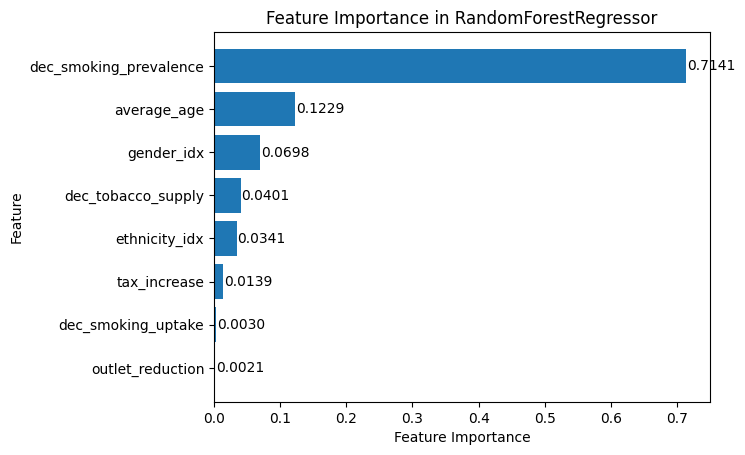

In [9]:
display_importance(rf1_best)

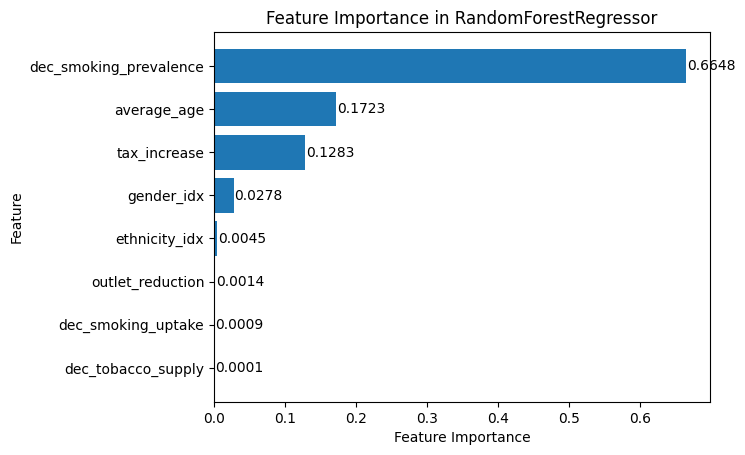

In [10]:
display_importance(rf2_best)